In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings(action='ignore')

from utils import preprocessing as my_prep
from utils import regression as my_reg
from utils import evaluate as my_eval

# Config

In [2]:
flag_y_next_quarter = True
flag_random_split = True
PREDICT_CATEGORY = '편의점'   # None means overall

# Data load

In [3]:
if flag_y_next_quarter:
    data_new = pd.read_csv("./data/seoul_preprocessed2_y_nextquarter.csv")
else:
    data_new = pd.read_csv("./data/seoul_preprocessed.csv", encoding='euc-kr')
# data_new = pd.read_csv("./data/seoul_preprocessed2_y_nextquarter.csv")
data_new.shape

(173745, 30)

### 분기별로 분할

In [4]:
quarters = ['2017_1', '2017_2', '2017_3', '2017_4', '2018_1', '2018_2', '2018_3', '2018_4', '2019_1', '2019_2', '2019_3']
datas = {}
for q in quarters:
    year, quarter = map(int, q.split("_"))
    
    bool_year = data_new.기준_년_코드==year
    bool_quarter = data_new.기준_분기_코드==quarter
    datas[q] = data_new[bool_year & bool_quarter] 
    
for key in datas.keys():
    print(key, datas[key].shape)

2017_1 (15795, 30)
2017_2 (15795, 30)
2017_3 (15795, 30)
2017_4 (15795, 30)
2018_1 (15795, 30)
2018_2 (15795, 30)
2018_3 (15795, 30)
2018_4 (15795, 30)
2019_1 (15795, 30)
2019_2 (15795, 30)
2019_3 (15795, 30)


# Split train, validate, test

In [5]:
trainfiles = ['2017_1', '2017_2', '2017_3', '2017_4', '2018_1', '2018_2', '2018_3']
validatefiles = []
testfiles = ['2018_4', '2019_1', '2019_2', '2019_3']  # 2019_1, 2019_2, 2019_3, 2019_4 맞추기

train, validate, test = my_prep.split_train_val_test_by_file(datas, trainfiles, validatefiles, testfiles, category=PREDICT_CATEGORY)
print(train.shape, validate.shape, test.shape)

[train] 2017_1 : (1147, 30), accumulate : (1147, 30)
[train] 2017_2 : (1147, 30), accumulate : (2294, 30)
[train] 2017_3 : (1147, 30), accumulate : (3441, 30)
[train] 2017_4 : (1147, 30), accumulate : (4588, 30)
[train] 2018_1 : (1147, 30), accumulate : (5735, 30)
[train] 2018_2 : (1147, 30), accumulate : (6882, 30)
[train] 2018_3 : (1147, 30), accumulate : (8029, 30)
[test] 2018_4 : (1147, 30), accumulate : (1147, 30)
[test] 2019_1 : (1147, 30), accumulate : (2294, 30)
[test] 2019_2 : (1147, 30), accumulate : (3441, 30)
[test] 2019_3 : (1147, 30), accumulate : (4588, 30)
(8029, 30) (0, 0) (4588, 30)


### split x, y

In [6]:
#x_header = [x for x in train.columns if '연령대' in x and x.find('연령대')==0]
x_header = [x for x in train.columns if '남성연령대' in x or '여성연령대' in x]

if flag_y_next_quarter:
    y_header = ['다음분기_매출_금액']
else:
    y_header = ['당월_매출_금액']
print(x_header, y_header)

['남성연령대_10_유동인_수', '남성연령대_20_유동인_수', '남성연령대_30_유동인_수', '남성연령대_40_유동인_수', '남성연령대_50_유동인_수', '남성연령대_60_유동인_수', '여성연령대_10_유동인_수', '여성연령대_20_유동인_수', '여성연령대_30_유동인_수', '여성연령대_40_유동인_수', '여성연령대_50_유동인_수', '여성연령대_60_유동인_수'] ['다음분기_매출_금액']


In [7]:
x_train, y_train = my_prep.split_xy(train, x_header, y_header)
# x_validate, y_validate = my_prep.split_xy(validate, x_header, y_header)
x_test, y_test = my_prep.split_xy(test, x_header, y_header)

print('train', x_train.shape, y_train.shape)
# print('validate', x_validate, y_validate)
print('test', x_test.shape, y_test.shape)

train (8029, 12) (8029, 1)
test (4588, 12) (4588, 1)


### Option(random split)

In [8]:
if flag_random_split:
    from sklearn.model_selection import train_test_split
    x_train = np.concatenate((x_train, x_test))
    y_train = np.concatenate((y_train, y_test))
    print('train', x_train.shape, y_train.shape)
    
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)
    print('train', x_train.shape, y_train.shape)
    print('test', x_test.shape, y_test.shape)

train (12617, 12) (12617, 1)
train (8831, 12) (8831, 1)
test (3786, 12) (3786, 1)


# Normalize, PCA

### Normalize

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scale = scaler.transform(x_train)
x_test_scale = scaler.transform(x_test)

scaler_y = StandardScaler().fit(y_train)
y_train_scale = scaler_y.transform(y_train)
y_test_scale = scaler_y.transform(y_test)

print('train', x_train_scale.shape, y_train_scale.shape)
print('test', x_test_scale.shape, y_test_scale.shape)

train (8831, 12) (8831, 1)
test (3786, 12) (3786, 1)


### PCA

In [10]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train_scale)
x_train_pca = pca.transform(x_train_scale)
x_test_pca = pca.transform(x_test_scale)
print(x_train_pca.shape, x_test_pca.shape)

(8831, 12) (3786, 12)


In [11]:
pca.explained_variance_ratio_.round(2)

array([0.78, 0.11, 0.07, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

In [12]:
top_n = 2
x_train_pca_selected = x_train_pca[:, :top_n]
x_test_pca_selected = x_test_pca[:, :top_n]
print(x_train_pca_selected.shape, x_test_pca_selected.shape)

(8831, 2) (3786, 2)


# Training

In [13]:
x_train_final, y_train_final = x_train_pca_selected, y_train_scale
x_test_final, y_test_final = x_test_pca_selected, y_test_scale

In [14]:
import lightgbm as lgb
model_LGBM = lgb.LGBMRegressor()
model_LGBM.fit(x_train_final, y_train_final)

LGBMRegressor()

# Evaluate

### LGBM

------- evaluate LGBM Regression -------
RMSE : 0.687080
R2 : 0.551451
4762.587684540198 3786
평균 오차 1%
최대 오차 484%
최소 오차 0%
----------------------------


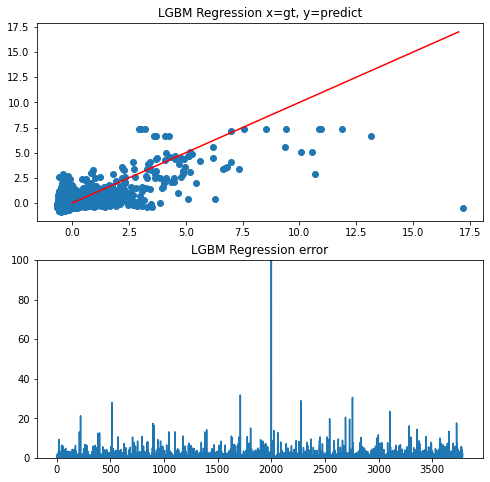

In [15]:
my_eval.eval_regression(y_test_final, model_LGBM.predict(x_test_final), scaler=scaler_y, model_name='LGBM Regression')

# Conclusion

##### 정답 값이 너무 비슷? 몇명만 너무 큼? 
##### 큰 의미가 없나?

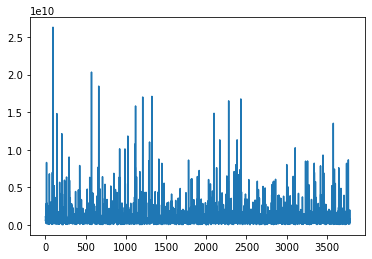

In [16]:
plt.plot(y_test)

In [17]:
print('MLP', int(scaler_y.inverse_transform([-0.02651767])))
print('LR', int(scaler_y.inverse_transform([-0.06412931])))
#print('SVR', int(scaler_y.inverse_transform([-0.02651767])))
print('Elastic', int(scaler_y.inverse_transform([4.09963574e-10])))    #
print('ground truth', y_test[0, 0])

MLP 942768924
LR 887328009
Elastic 981856928
ground truth 1076093755


# TODO

1) 전처리  
- 가중치부여    

2) 차원축소  
 - wrapper, PCA    

3) 증분  
 - 회귀 증분?    

4) 모델 
 - LGBM, MLP monitoring  

5) 학습/검증 분할
 - random
 - k-fold(train,validate)/test
 - sequence  
 
6) 분석, 결론
 - MSE, R2
 - 오차
 - 시각화 (지도?)

버릴건 버려야